# Lecture 5: Source of Bias
This notebook is a part of the [Algorithmic Fairness, Accountability and Ethics (Spring 2025)](https://learnit.itu.dk/course/view.php?id=3024271) at [IT-University of Copenhagen](https://itu.dk/)

#### Ex.5.1: Data Analysis on the Berkeley admissions in 1973

1. The dataset `BerkeleyAdmissionsData.csv` is a three-way table that presents admissions data at the University of California, Berkeley in 1973 according to the variables department (A, B, C, D, E), gender (male, female), and outcome (admitted, denied) encoded as Yes and No.
2. Load the dataset
3. Did Berkley admissions in 1973 suffered from gender bias? Why or why not?
    * What methods or metric did you use?
    * Could you find any signs of the Simpson's Paradox (a form of aggregation bias)? What methods did you use? 
    * When you complete the exercise, have a look at [the original paper](https://homepage.stat.uiowa.edu/~mbognar/1030/Bickel-Berkeley.pdf)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns



In [2]:
df = pd.read_csv("data/BerkeleyAdmissionsData.csv")

df

,Dept,Male Yes,Male No,Female Yes,Female No
0,A,512,313,89,19
1,B,313,207,17,8
2,C,120,205,202,391
3,D,138,279,131,244
4,E,53,138,94,299
5,F,22,351,24,317
6,All,1158,1493,557,1278


In [3]:
## I'm gonna make a new df with various aggregations
df_agg = pd.DataFrame()
df_agg['Dept'] = df['Dept']

# Get total applicants for male, female and overall
df_agg['Male_applicants'] = df['Male Yes'] + df['Male No']
df_agg['Female_applicants'] = df['Female Yes'] + df['Female No']
df_agg['Overall_applicants'] = df_agg['Male_applicants'] + df_agg['Female_applicants']

# Get admission rates for male, female and overall
df_agg['Male_admit_rate'] = (df['Male Yes'] / df_agg['Male_applicants']).round(2)
df_agg['Female_admit_rate'] = (df['Female Yes'] / df_agg['Female_applicants']).round(2)
df_agg['Overall_admit_rate'] = ((df['Male Yes'] + df['Female Yes']) / df_agg['Overall_applicants']).round(2)

df_agg

,Dept,Male_applicants,Female_applicants,Overall_applicants,Male_admit_rate,Female_admit_rate,Overall_admit_rate
0,A,825,108,933,0.62,0.82,0.64
1,B,520,25,545,0.60,0.68,0.61
2,C,325,593,918,0.37,0.34,0.35
3,D,417,375,792,0.33,0.35,0.34
4,E,191,393,584,0.28,0.24,0.25
5,F,373,341,714,0.06,0.07,0.06
6,All,2651,1835,4486,0.44,0.30,0.38


Overall, 38% applicants were accepted.

44% of male applicants were accepted, whilst 30% of female applicants were accepted.

Is this evidence of gender bias in the admission process? It seems P(Accepted|Male) > P(Accepted|Female)

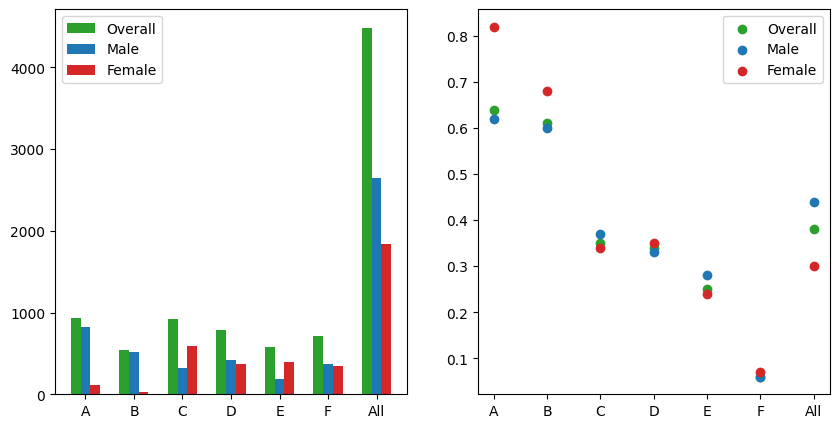

In [4]:
_,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].bar([x-0.2 for x in range(len(df_agg.columns))], df_agg['Overall_applicants'], width=0.2, label='Overall', color='tab:green')
ax[0].bar(df_agg.Dept, df_agg['Male_applicants'], label='Male', width=0.2, color='tab:blue')
ax[0].bar([x+0.2 for x in range(len(df_agg.columns))], df_agg['Female_applicants'], width=0.2, label='Female', color='tab:red')

ax[1].scatter(df_agg.Dept, df_agg['Overall_admit_rate'], label='Overall', color='tab:green')
ax[1].scatter(df_agg.Dept, df_agg['Male_admit_rate'], label='Male', color='tab:blue')
ax[1].scatter(df_agg.Dept, df_agg['Female_admit_rate'], label='Female', color='tab:red')

ax[0].legend()
ax[1].legend();

Something looks odd here.

Overall, men have a greater rate of admission than women, 44% vs 30%, yet when we look at these 6 depts, 4 out of the 6 have a higher admission rate for women than men.

In [5]:
#Lets consider expected admission rate for each department

df['Expected_Male_admissions'] = df_agg.Male_applicants * df_agg.Overall_admit_rate


df['Expected_Female_admissions'] = df_agg.Female_applicants * df_agg.Overall_admit_rate

df['Male_difference'] = df['Male Yes'] - df['Expected_Male_admissions']
df['Female_difference'] = df['Female Yes'] - df['Expected_Female_admissions']

df

,Dept,Male Yes,Male No,Female Yes,Female No,Expected_Male_admissions,Expected_Female_admissions,Male_difference,Female_difference
0,A,512,313,89,19,528.00,69.12,-16.00,19.88
1,B,313,207,17,8,317.20,15.25,-4.20,1.75
2,C,120,205,202,391,113.75,207.55,6.25,-5.55
3,D,138,279,131,244,141.78,127.50,-3.78,3.50
4,E,53,138,94,299,47.75,98.25,5.25,-4.25
5,F,22,351,24,317,22.38,20.46,-0.38,3.54
6,All,1158,1493,557,1278,1007.38,697.30,150.62,-140.30


### Summary from the paper linked at the beginning:

`Examination of aggregate data on graduate admissions to the University of California, Berkeley, for fall 1973 shows a clear but misleading pattern of bias against female applicants.`

`Examination of the disaggregated data reveals few decision-making units that show statistically significant departures from expected frequencies of female admissions, and about as many units appear to favor women as to favor men. If the data are properly pooled, taking into account the autonomy of departmental decision making, thus correcting for the tendency of women to apply to graduate departments that are more difficult for applicants of either sex to enter, there is a small but statistically significant bias in favor of women. The graduate departments that are easier to enter tend to be those that require more mathematics in the undergraduate preparatory curriculum.`

`The bias in the aggregated data stems not from any pattern of discrimination on the part of admissions committees, which seem quite fair on the whole, but apparently from prior screening at earlier levels of the educational system. Women are shunted by their socialization and education toward fields of graduate study that are generally more crowded, less productive of completed degrees, and less well funded, and that frequently offer poorer professional employment prospects.`


#### Ex.5.2: Correlation 
*Inspired by the [Social Data Science and Visualisation Lecture](https://github.com/suneman/socialdata2023/blob/main/lectures/Week2.ipynb) by Sune Lehmann*

You will be working with the `Data1.tsv`, `Data2.tsv`, `Data3.tsv`, `Data4.tsv`. The format is .tsv, which stands for tab separated values.  Each file has two columns (separated using the tab character). The first column is $x$-values, and the second column is $y$-values.

1. **Calculate simple statistics**
    1. Calculate *mean* and *variance* for $x$ and $y$ variables for each dataset (separately).
    2. Calculate *Pearson's* and *Spearman's* correlation coefficients between $x$ and $y$ variables for each dataset (separatelly)
    3. Fit a straight line trought each dataset. In Python you can do it like:
    ```
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    ```
    4. You should get a set of results for each dataset. Compare them, what do you observe?
2. **Visualise datasets**
    1. For each dataset make a plot (including the linear fit)
    2. What do you observe? How does it correspond to the results from the previous subsection?
    3. After you complete the exercise [look here](https://en.wikipedia.org/wiki/Anscombe%27s_quartet).

In [6]:
df_corr = pd.DataFrame()

for i in range(1,5):
    temp = pd.read_csv(f'data/Data{i}.tsv', sep='\t', header=None)
    df_corr[[f'x{i}', f'y{i}']] = temp


df_corr.describe() #means and std are near identical (for xs and ys separately)

,x1,y1,x2,y2,x3,y3,x4,y4
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,9.000000,7.500909,9.000000,7.500909,9.000000,7.500000,9.000000,7.500909
std,3.316625,2.031568,3.316625,2.031657,3.316625,2.030424,3.316625,2.030579
min,4.000000,4.260000,4.000000,3.100000,4.000000,5.390000,8.000000,5.250000
25%,6.500000,6.315000,6.500000,6.695000,6.500000,6.250000,8.000000,6.170000
50%,9.000000,7.580000,9.000000,8.140000,9.000000,7.110000,8.000000,7.040000
75%,11.500000,8.570000,11.500000,8.950000,11.500000,7.980000,8.000000,8.190000
max,14.000000,10.840000,14.000000,9.260000,14.000000,12.740000,19.000000,12.500000


Pearsons: 0.816, Spearmans: 0.818, Slope: 0.500, Intercept: 3.000, R-value: 0.816, P-value: 0.002, Std-err: 0.118
Pearsons: 0.816, Spearmans: 0.691, Slope: 0.500, Intercept: 3.001, R-value: 0.816, P-value: 0.002, Std-err: 0.118
Pearsons: 0.816, Spearmans: 0.991, Slope: 0.500, Intercept: 3.002, R-value: 0.816, P-value: 0.002, Std-err: 0.118
Pearsons: 0.817, Spearmans: 0.500, Slope: 0.500, Intercept: 3.002, R-value: 0.817, P-value: 0.002, Std-err: 0.118


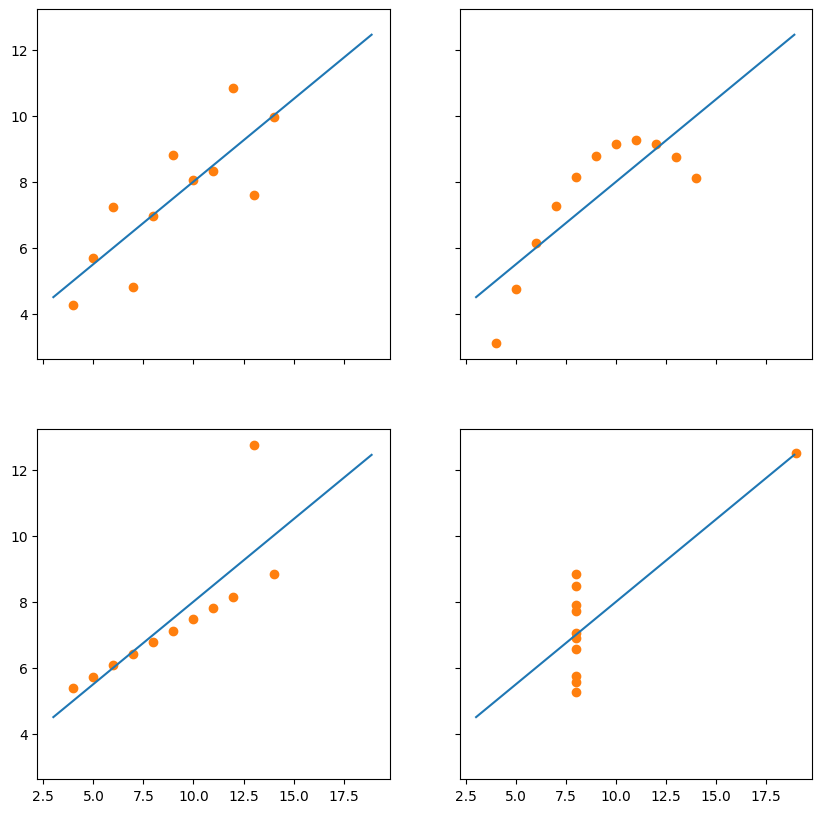

In [7]:
_,ax = plt.subplots(2,2,figsize=(10,10), sharex=True, sharey=True)
ax = ax.flatten()

x_ = np.arange(3, 19, 0.1)

for i in range(1,5):
    x = df_corr[f'x{i}']
    y = df_corr[f'y{i}']

    pears_corr = np.corrcoef(x,y)[0,1]
    spear_corr = stats.spearmanr(x,y)[0]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    print(f'Pearsons: {pears_corr:.3f}, Spearmans: {spear_corr:.3f}, Slope: {slope:.3f}, Intercept: {intercept:.3f}, R-value: {r_value:.3f}, P-value: {p_value:.3f}, Std-err: {std_err:.3f}')

    ax[i-1].plot(x_, slope*x_ + intercept, color='tab:blue') 

    ax[i-1].scatter(x,y, color='tab:orange');

# You have likely seen these plots before in some form or another: Anscombe's quartet. We have near identical stats, apart from Spearmans coefficient, but the plots are quite different 

#### Ex.5.3: Data Analysis on the ProPublica Dataset 

**The goal of this exercise is to have you interact with the COMPAS dataset, to clean the dataset for analysis, extract insight, visualize findings, and replicate a part of the ProPublica's analysis. If you have worked already with the COMPAS dataset and find the exercise boring or redundant, consider working on the other exercises, or working on analyzing possible biases in a data set of your choice**

Please remember to use materials on [LearnIT](https://learnit.itu.dk/course/view.php?id=3022793) under Lecture 5 – Read before class:
* Social Data: Biases, Methodological Pitfalls, and Ethical Boundaries
* A Survey on Bias and Fairness in Machine Learning 

Also refer to the [How we analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) (Article) and [ProPublica Github Repository](https://github.com/propublica/compas-analysis/).


#### Loading and surveying the data
* Load the dataset `compas-scores-two-years.csv`

In [8]:
compas = pd.read_csv('data/compas-scores-two-years.csv')
compas.c_jail_in = pd.to_datetime(compas.c_jail_in)
compas.c_jail_out = pd.to_datetime(compas.c_jail_out)
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


#### Columns of Interest:
* `age` - Age of the defendant. It is numeric.
* `age_cat` - Category of Age. It can be < 25, 25-45, >45.
* `sex` - Sex of the defendant. It is either 'Male' or 'Female'
* `race` - Race of the defendant. It can be 'African-American', 'Caucasian', 'Hispanic', 'Asian', or 'Other'.
* `c_charge_degree` - Degree of the crime. It is either M (Misdemeanor), F (Felony), or O (not causing jail time).
* `priors_count` - Count of prior crimes committed by the defendant. It is numeric.
* `days_b_screening_arrest` - Days between the arrest and COMPAS screening.
* `decile_score` - The COMPAS score predicted by the system. It is between 0-10.
* `score_text` - Category of decile score. It can be Low (1-4), Medium (5-7), and High (8-10).
* `is_recid` - A variable to indicate if recidivism was done by the defendant. It can be 0, 1, -1.
* `two_year_recid` - A variable to indicate if recidivism was done by the defendant within two years.
* `c_jail_in` - Time when the defendant was jailed.
* `c_jail_out` - Time when the defendant was released from the jail.

#### Data Cleaning
Now that we have surveyed the dataset, let's look into cleaning the data. This data-cleaning is largely based off of ProPublica's methods. Requerements for the data filtering:
1. We only focus on cases where the COMPAS scored crime happened within +/- 30 days from when the person was arrested (if the value is missing, the record shoudl be removed). 
2. Then, we also get rid of cases where is_recid is -1 since we only want binary values for the purpose of our model (0 for no recidivism, 1 for yes recidivism). 
3. Finally, we don't want the c_charge_degree to be "O" which denotes ordinary traffic offenses (not as serious of a crime). 

Finish cleaning the dataset by filling in the code below based on the description above. The cleaned dataset should have 6172 records and 13 features.

(***Optional**) Create a "Lenghts of stay in jail" feature (you can compute this feature using `c_jail_in` and `c_jail_out`) and use it in the exercise*

In [9]:
print(compas.shape)

compas.dropna(subset=['days_b_screening_arrest'], inplace=True) #remove NaNs here
print(compas.shape)

compas = compas[compas['c_charge_degree'] != 'O'].copy() # removes all rows where c_charge_degree is 'O'
print(compas.shape) #apparently there were none...

#remove rows where days_b_screening_arrest is more than 30
compas = compas[abs(compas['days_b_screening_arrest']) <=30].copy()

# keep only needed columns
compas = compas[['age', 'age_cat', 'sex', 'race', 'c_charge_degree', 
                 'priors_count', 'days_b_screening_arrest', 'decile_score',
                 'score_text', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']].copy()
print(compas.shape)

(7214, 53)
(6907, 53)
(6907, 53)
(6172, 13)


#### Exploratory data Analysis

First, study basic statistics of the dataset (in case you make plots, make sure that you provide labels and titles)
* Frequency of different attributes (such as race, age, decile score, prio_counts)
* General descriptive statistics of the dataset

In [10]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6172 entries, 0 to 7213
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   age                      6172 non-null   int64         
 1   age_cat                  6172 non-null   object        
 2   sex                      6172 non-null   object        
 3   race                     6172 non-null   object        
 4   c_charge_degree          6172 non-null   object        
 5   priors_count             6172 non-null   int64         
 6   days_b_screening_arrest  6172 non-null   float64       
 7   decile_score             6172 non-null   int64         
 8   score_text               6172 non-null   object        
 9   is_recid                 6172 non-null   int64         
 10  two_year_recid           6172 non-null   int64         
 11  c_jail_in                6172 non-null   datetime64[ns]
 12  c_jail_out               6172 non-null 

In [11]:
compas.sex.value_counts(normalize=True)

sex
Male      0.809624
Female    0.190376
Name: proportion, dtype: float64

In [12]:
compas.race.value_counts(normalize=True)

race
African-American    0.514420
Caucasian           0.340732
Hispanic            0.082469
Other               0.055574
Asian               0.005023
Native American     0.001782
Name: proportion, dtype: float64

In [13]:
compas.is_recid.value_counts(normalize=True), compas.two_year_recid.value_counts(normalize=True)

(is_recid
 0    0.515554
 1    0.484446
 Name: proportion, dtype: float64,
 two_year_recid
 0    0.54488
 1    0.45512
 Name: proportion, dtype: float64)

In [14]:
compas.decile_score.value_counts(normalize=True)

decile_score
1     0.208360
2     0.133182
4     0.107907
3     0.104828
5     0.094297
6     0.085710
7     0.080363
9     0.068049
8     0.068049
10    0.049255
Name: proportion, dtype: float64

In [15]:
compas.decile_score.mean(), compas[compas.sex=='Male'].decile_score.mean(), compas[compas.sex=='Female'].decile_score.mean()

(np.float64(4.41850291639663),
 np.float64(4.501901140684411),
 np.float64(4.0638297872340425))

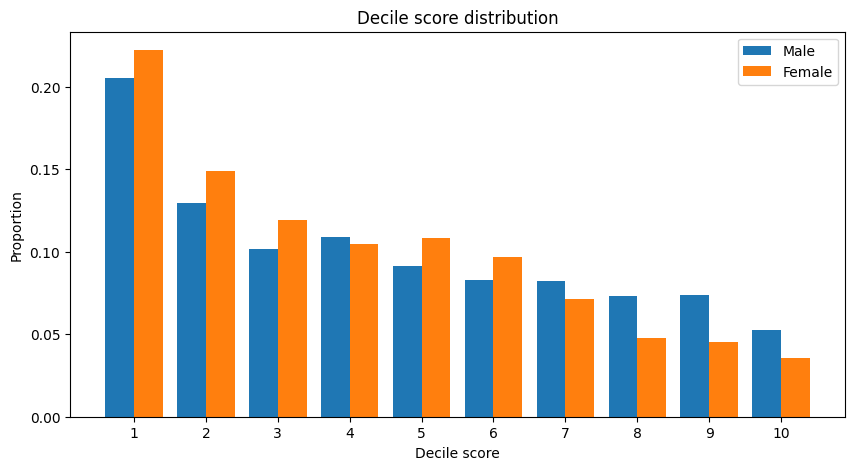

In [16]:
temp = pd.DataFrame(compas.groupby(['sex', 'decile_score']).count().age)

temp.reset_index(inplace=True)
temp.rename(columns={'age':'count'}, inplace=True)

_, ax = plt.subplots(figsize=(10,5))

ax.bar(temp[temp.sex=='Male'].decile_score-0.2, temp[temp.sex=='Male']['count']/temp[temp.sex=='Male']['count'].sum(), color='tab:blue', width=0.4, label='Male')
ax.bar(temp[temp.sex=='Female'].decile_score+0.2, temp[temp.sex=='Female']['count']/temp[temp.sex=='Female']['count'].sum(), color='tab:orange', width=0.4, label='Female')

ax.set_title('Decile score distribution')
ax.set_xlabel('Decile score')
ax.set_ylabel('Proportion')
ax.set_xticks(range(1,11))
ax.legend();

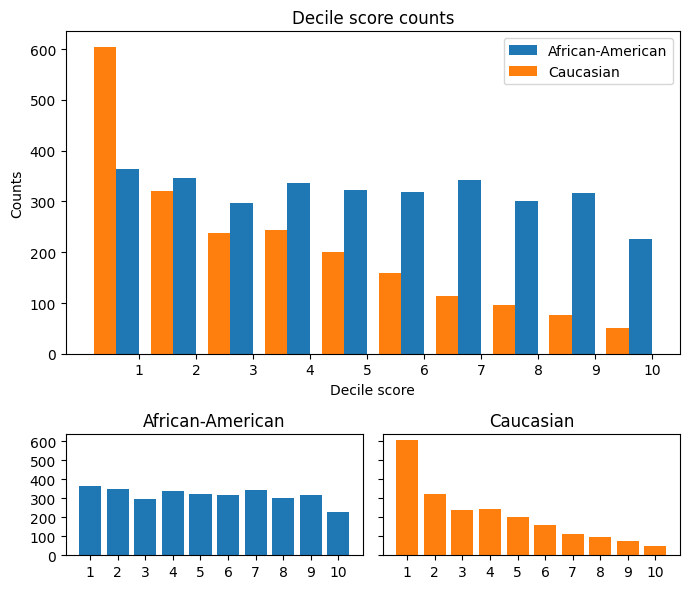

In [17]:
temp = pd.DataFrame(compas.groupby(['race', 'decile_score']).count().age)

temp.reset_index(inplace=True)
temp.rename(columns={'age':'count'}, inplace=True)

cols = ['tab:blue', 'tab:orange']
_, ax = plt.subplot_mosaic(mosaic=[['all', 'all'],
                                   ['all', 'all'],
                                   ["a", "b"]], figsize=(7,6), sharey=True)
axes = ["a", "b"]
a = 0.2

#I'm looking at 2 groups here, as per ProPublica's analysis
for i, r in enumerate(['African-American', 'Caucasian']):
    ax['all'].bar(temp[temp.race==r].decile_score-a, temp[temp.race==r]['count'], color=cols[i], width=0.4, label=r)
    ax[axes[i]].bar(temp[temp.race==r].decile_score, temp[temp.race==r]['count'], color=cols[i], label=r)
    ax[axes[i]].set_xticks(range(1,11))
    ax[axes[i]].set_title(f'{r}')
    a+=0.4

ax['all'].set_title('Decile score counts')
ax['all'].set_xlabel('Decile score')
ax['all'].set_ylabel('Counts')
ax['all'].set_xticks(range(1,11))
ax['all'].legend(loc='upper right')
plt.tight_layout();

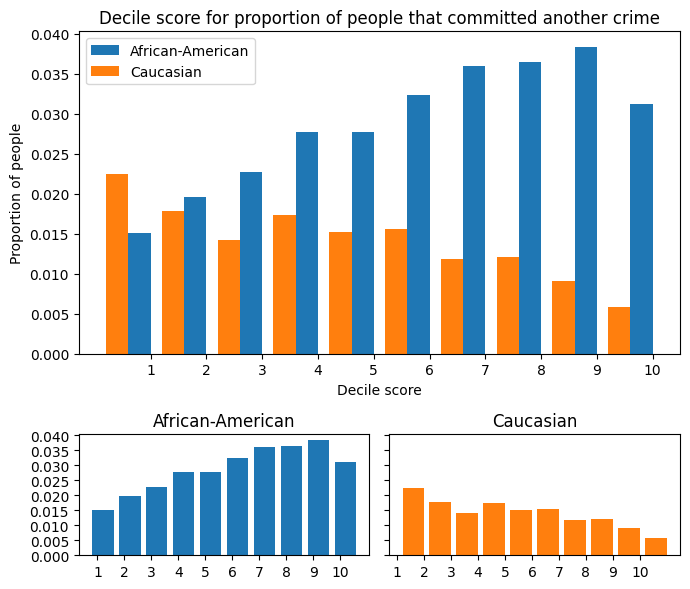

In [18]:
temp = pd.DataFrame(compas.groupby(['race', 'decile_score', 'is_recid']).count().age)

temp.reset_index(inplace=True)
temp.rename(columns={'age':'count'}, inplace=True)
n = temp['count'].sum()

temp = temp[(temp.race=='African-American') | (temp.race=='Caucasian')]
#n = temp['count'].sum()

temp['proportion_correct'] = 0.0

for i in ['African-American', 'Caucasian']:
    for j in range(1,11):
        t = temp[(temp.race==i)&(temp.decile_score==j)]
        idx = t.index
        temp.loc[idx[0], 'proportion_correct'] = t.loc[idx[0]]['count']/n
        temp.loc[idx[1], 'proportion_correct'] = t.loc[idx[1]]['count']/n

temp2 = temp[temp.is_recid==1]
_, ax = plt.subplot_mosaic(mosaic=[['all', 'all'],
                                   ['all', 'all'],
                                   ["a", "b"]], figsize=(7,6), sharey=True)
axes = ["a", "b"]
a = 0.2

for i, r in enumerate(['African-American', 'Caucasian']):
    ax['all'].bar(temp2[temp2.race==r].decile_score-a, temp2[temp2.race==r]['proportion_correct'], color=cols[i], width=0.4, label=r)
    ax[axes[i]].bar(temp2[temp2.race==r].decile_score+a, temp2[temp2.race==r]['proportion_correct'], color=cols[i], label=r)
    ax[axes[i]].set_xticks(range(1,11))
    ax[axes[i]].set_title(f'{r}')
    a+=0.4

ax['all'].set_title('Decile score for proportion of people that committed another crime')
ax['all'].set_xlabel('Decile score')
ax['all'].set_ylabel('Proportion of people')
ax['all'].set_xticks(range(1,11))
ax['all'].legend(loc='upper left')
plt.tight_layout();

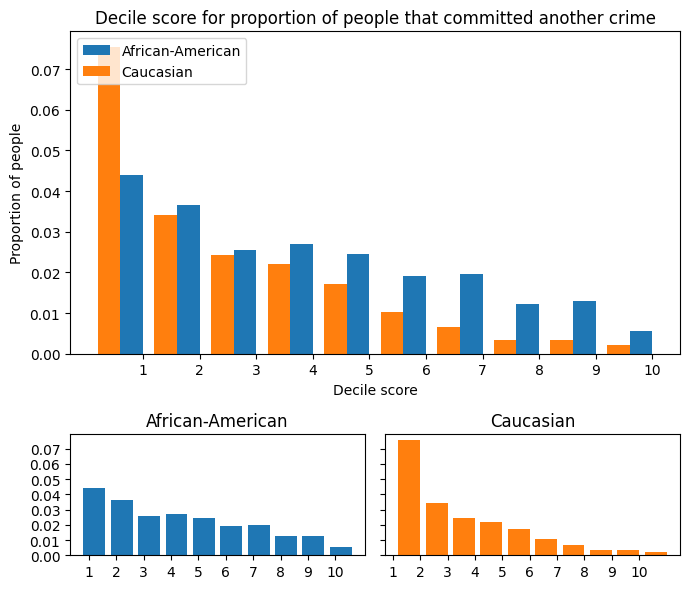

In [19]:
temp2 = temp[temp.is_recid==0]
_, ax = plt.subplot_mosaic(mosaic=[['all', 'all'],
                                   ['all', 'all'],
                                   ["a", "b"]], figsize=(7,6), sharey=True)
axes = ["a", "b"]
a = 0.2

for i, r in enumerate(['African-American', 'Caucasian']):
    ax['all'].bar(temp2[temp2.race==r].decile_score-a, temp2[temp2.race==r]['proportion_correct'], color=cols[i], width=0.4, label=r)
    ax[axes[i]].bar(temp2[temp2.race==r].decile_score+a, temp2[temp2.race==r]['proportion_correct'], color=cols[i], label=r)
    ax[axes[i]].set_xticks(range(1,11))
    ax[axes[i]].set_title(f'{r}')
    a+=0.4

ax['all'].set_title('Decile score for proportion of people that committed another crime')
ax['all'].set_xlabel('Decile score')
ax['all'].set_ylabel('Proportion of people')
ax['all'].set_xticks(range(1,11))
ax['all'].legend(loc='upper left')
plt.tight_layout();

#### Bias Analysis

* Study the distribution of the recidivism score `decile_score` for different categories: does recidivism have the same distribution for different races? For different genders?
    * Make sure that your plots are comparable (e.g. axes have same scale)
* If it is not distributed in the same way, which biases do you identify in the input dataset that can lead to different distributions? Think about "how data can unintentionally discriminate" from the theory class
* Is there a measurement bias? Explain
* Is there a population bias? Explain
* Is there a sampling bias? Explain
* Look at the correlation between features. What can you notice? How could this affect the recidivism score? (*you can use `nominal` method from `dython` package to find correlations between categorical and continious variables (if not sure check the lecture slides). Read documentation to get more info.*)


#### Replicating ProPublica Analysis
Propublica used the COMPAS scores to predict recidivism if the score was >=5 and no recidivism if the score was < 5.

This is not a complete analysis since it solely uses the decile score and does a hard thresholding for prediction, discarding all other aspects of individuals. But let's reproduce it anyway.

Let's call this thresholded version of predicted recividism `predicted_recid`.

* Compute and compare the confusion matrix for each of the races
* Compute and compare the error rate, false positive rate, and false negative rate for each of the races
* What do you conclude?

#### References
- https://github.com/propublica/compas-analysis/
- https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm
- https://mit-serc.pubpub.org/pub/risk-prediction-in-cj/release/2